#### Sparse Bayesian learning: accelerated method by Faul and Tipping
###### Description: polynomial basis functions, scalar output, scalar input.
###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, math, sys

In [2]:
polyPower = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] # powers of polynomial basis
polyPower = [0,1,2,3,4,5,6] # powers of polynomial basis
N = len(polyPower) # number of coefficients 
rho0 = 20 # initial error precision
rhoTrue = 25 # used for plotting only
alpha0 = [1e-03]*N # All basis functions in cluded in the model at the start 
#alpha0 = [np.inf]*N; alpha0[0] = 1e-03 # only 0th basis in the model at the start 
Wlim = [-6,6]  # xlim for plotting pdf plots
Nsbl = 55 # number of SBL iterations (add 5 to what you want to run, for plotting ease)

In [3]:
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
M = len(Yobs)
Phi = np.zeros((M,N))
for i in range(0,M):
    for j in range(0,N):
        Phi[i,j] = Xobs[i]**polyPower[j]
mpl.rcParams.update({'font.size':14})
#mpl.rcParams.update({'figure.figsize':(6,4)})

In [4]:
def updatemPevid(alphai,rhoi):
    Ainv = np.diag(1/alphai)
    Bi = np.matmul(Phi,np.matmul(Ainv,np.transpose(Phi))) + np.identity(M)/rhoi
    Binvi = np.linalg.inv(Bi)
    Ki = np.matmul(Ainv,np.matmul(np.transpose(Phi),Binvi))
    Pi = Ainv - np.matmul(Ki,np.matmul(Phi,Ainv))
    mi = np.matmul(Ki,Yobs)
    evidi = st.multivariate_normal.pdf(Yobs,[0]*M,Bi)
    return mi, Pi, evidi, Binvi

In [5]:
alpha = np.zeros((N,Nsbl))
gamma = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl))
Wmu = np.zeros((N,Nsbl))
evid = [0]*Nsbl
gof = [0]*Nsbl
rho = [0]*Nsbl
P = np.zeros((N,N))
alpha[:,0] = alpha0;
rho[0] = rho0;
curList = list(range(N))
for i in range(0,N):
    if alpha0[i] != np.inf: 
        gamma[i,0] = 1
for j in range(0,Nsbl-1):
    i=j%N
    if i == 0:  
        np.random.shuffle(curList)
    Wmu[:,j], P, evid[j], Binv = updatemPevid(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    for ii in range(0,N):
        if alpha[ii,j] != np.inf: 
            gamma[ii,j] = 1 - alpha[ii,j]*Wvar[ii,j]
        else:
            gamma[ii,j] = 0.0
    sbari = np.matmul(np.transpose(Phi[:,curList[i]]),np.matmul(Binv,Phi[:,curList[i]]))
    qbari = np.matmul(np.transpose(Phi[:,curList[i]]),np.matmul(Binv,Yobs))
    si = sbari/(1-sbari/alpha[curList[i],j])
    qi = qbari/(1-sbari/alpha[curList[i],j])
    if qi**2 > si:
        alpha[curList[i],j] = (si**2)/(qi**2-si)
        #print('Try: ',curList[i],' ; Add/update')
    else:
        alpha[curList[i],j] = np.inf
        #print('Try: ',curList[i],' ; remove/neglect')
    alpha[:,j+1] = alpha[:,j]
    gamma[:,j+1] = gamma[:,j]
    rho[j+1] = (M - np.sum(gamma[:,j]))/(np.power(np.linalg.norm(Yobs-np.matmul(Phi,Wmu[:,j])),2))
    gof[j] = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,Wmu[:,j]),np.identity(M)/rho[j])
print(alpha[:,-1],rho[-2],np.log(evid[-2]))

[0.93922972        inf 1.31037651        inf        inf        inf
        inf] 26.809130913821285 5.357611182412061


## Plotting for SBL iteration

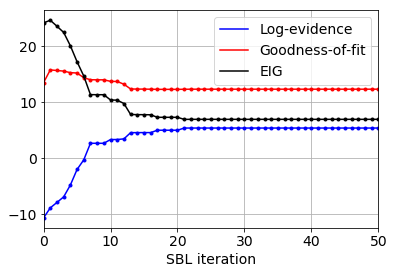

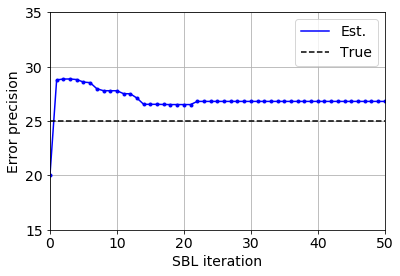

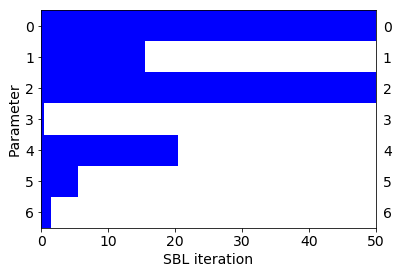

In [6]:
plt.figure(1)
plt.plot(np.log(evid[:-1]),'b.')
plt.plot(np.log(evid[:-1]),'b-',label='Log-evidence')
plt.plot(np.log(gof[:-1]),'r.')
plt.plot(np.log(gof[:-1]),'r-',label='Goodness-of-fit')
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'k.')
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'k-',label='EIG')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlabel('SBL iteration')
plt.xlim([0,Nsbl-5])
plt.savefig('SBLFAST_EVIDALL.eps',bbox_inches='tight')
plt.figure(2)
plt.plot(rho[:-1],'b.')
plt.plot(rho[:-1],'b-',label='Est.')
plt.plot([0,50],[rhoTrue,rhoTrue],'k--',label='True')
plt.legend(loc='best', numpoints = 1); plt.grid(True)
plt.xlim([0,Nsbl-5])
plt.ylim([rhoTrue-10,rhoTrue+10])
plt.ylabel('Error precision')
plt.xlabel('SBL iteration');
plt.savefig('SBLFAST_RHO.eps',bbox_inches='tight')
fig, ax = plt.subplots()
cmap = mpl.colors.ListedColormap(['white', 'blue'])
bounds = [0,0.01,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(gamma, cmap=cmap, aspect='auto',norm=norm)
ax.tick_params(labelright=True)
ax.set_yticks(np.arange(0, N, 1))
plt.xlim([0,Nsbl-5])
plt.ylabel('Parameter')
plt.xlabel('SBL iteration')
plt.savefig('SBLFAST_SPARSITY.eps',bbox_inches='tight')

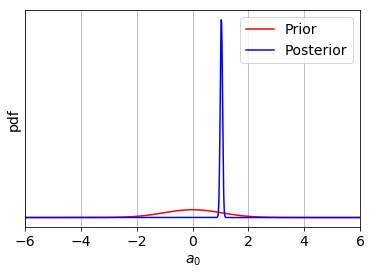

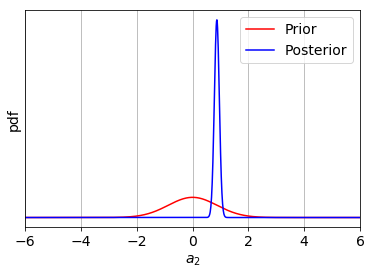

In [7]:
Ngrid = 1000
Wpost = np.zeros((N,Ngrid))
Wprior = np.zeros((N,Ngrid))
Wgrid = np.zeros((N,Ngrid))
for i in range(0,N):
    Wgrid[i,:] = np.linspace(Wlim[0],Wlim[1],Ngrid)
    if alpha[i,-2] != np.inf:
        Wpost[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],Wmu[i,-2],Wvar[i,-2])
        Wprior[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],0,1/alpha[i,-2])
    else:
        Wpost[i,int(Ngrid/2)] = 100
        Wpost[i,int(Ngrid/2)] = 100
for i in range(0,N):
    if alpha[i,-2] != np.inf:
        fig = plt.figure(+i)
        plt.plot(Wgrid[i,:],Wprior[i,:],'r-',label='Prior')
        plt.plot(Wgrid[i,:],Wpost[i,:],'b-',label='Posterior')
        plt.grid(True)
        plt.yticks([])
        plt.xlabel(r'$a_'+str(i)+'$')
        plt.ylabel('pdf')
        plt.xlim(Wlim[0],Wlim[1])
        plt.legend(loc='best', numpoints = 1)
        plt.savefig('SBLFAST_PDF_W'+str(i)+'.eps',bbox_inches='tight')

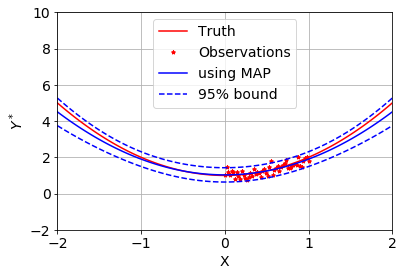

In [8]:
def fn(X):
    return np.polyval([1,0,1],X)
Mnew = 100
Xrnge = [-2,2]
Yrnge = [-2,10]
Xnew = np.linspace(Xrnge[0],Xrnge[1],Mnew)
PhiNew = np.zeros((Mnew,N))
for i in range(0,Mnew):
    for j in range(0,N):
        PhiNew[i,j] = Xnew[i]**polyPower[j]
PredVar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[-1]
PredMean = np.matmul(PhiNew,Wmu[:,-2])
Ytrue = fn(Xnew)
fig = plt.figure(N+10)
plt.plot(Xnew,Ytrue,'r-',label='Truth')
plt.plot(Xobs,Yobs,'r*',label='Observations',markersize=4)
plt.plot(Xnew,PredMean,'b-',label='using MAP')
plt.plot(Xnew,PredMean+2*np.sqrt(np.diag(PredVar)),'b--',label='95% bound')
plt.plot(Xnew,PredMean-2*np.sqrt(np.diag(PredVar)),'b--')
plt.grid(True)
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.ylim(Yrnge)
plt.xlim([Xrnge[0],Xrnge[1]])
plt.legend(loc='best', numpoints = 1)
plt.savefig('SBLFAST_PRED.eps',bbox_inches='tight')